In [1]:
!pip install scratchai-nightly  # for adversarial attack
!pip install torchvision==0.9.1 # deep learning models
!pip install flashtorch         # visualization based on activation maximization 
!pip install mapextrackt        # visualization of neural network saliency map

     |████████████████████████████████| 87 kB 3.0 MB/s 
     |████████████████████████████████| 17.4 MB 568 kB/s 
     |████████████████████████████████| 804.1 MB 2.6 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.8.1 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.8.1 which is incompatible.
  Created wheel for flashtorch: filename=flashtorch-0.1.3-py3-none-any.whl size=26245 sha256=3105638124af

In [2]:
# download and store locally a stop sign image
stop_sign_url = 'https://static01.nyt.com/images/2011/12/11/magazine/11wmt1/mag-11WMT-t_CA0-jumbo.jpg'
!mkdir input_images
!wget https://static01.nyt.com/images/2011/12/11/magazine/11wmt1/mag-11WMT-t_CA0-jumbo.jpg -O input_images/stop.jpg

--2022-02-10 03:13:23--  https://static01.nyt.com/images/2011/12/11/magazine/11wmt1/mag-11WMT-t_CA0-jumbo.jpg
Resolving static01.nyt.com (static01.nyt.com)... 151.101.1.164, 151.101.65.164, 151.101.129.164, ...
Connecting to static01.nyt.com (static01.nyt.com)|151.101.1.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92066 (90K) [image/jpeg]
Saving to: ‘input_images/stop.jpg’

input_images/stop.j 100%[===================>]  89.91K  --.-KB/s    in 0.02s   

2022-02-10 03:13:24 (5.02 MB/s) - ‘input_images/stop.jpg’ saved [92066/92066]



In [3]:
# suppress error
import logging as logging
import sys as sys
logging.disable(sys.maxsize) 

# import the library
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from scratchai import *

from flashtorch.activmax import GradientAscent
from MapExtrackt import FeatureExtractor
from torch.distributions import Normal


# set parameters
stop_sign_path = 'input_images/stop.jpg' #stop sign image path
true_class = 919 # imagenet id for street sign


# function handle to get prediction more easily
def get_prediction(image, model):
    #assumes img and net are datasets and models trained using imagenet dataset  
    confidences = model(image.unsqueeze(0))
    class_idx = torch.argmax(confidences, dim=1).item()
    class_label = datasets.labels.imagenet_labels[class_idx]
    return class_label, confidences[0, class_idx].item(), class_idx

**1a: Making prediction**

In [4]:
# load and preprocess the stop sign image
img = imgutils.load_img(stop_sign_path)
img = imgutils.get_trf('rz256_cc224_tt_normimgnet')(img) #normalize and reshape the input image

# REPLACE THE THREE DOTS WITH YOUR OWN CODE

net = models.resnet18(pretrained=True).eval()  # load resnet

# use the provided get_prediction function to predict the class of the stop sign image
get_prediction(img, net)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

('street sign', 13.558080673217773, 919)

**1b: Random perturbation**

epsilon=0.1
('street sign', 14.593377113342285, 919)


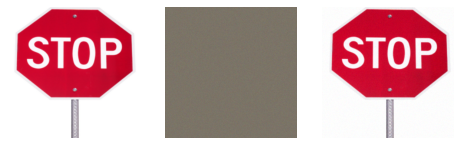

In [5]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

epsilon = 0.1 # set the epsilon

torch.manual_seed(0) # set the random seed when you use functions that uses sampling

noisy_img = attacks.noise(img, epsilon) # perform uniform random attack here [see the example in the Sec. 3.2.4 of the problem set]

print('epsilon=0.1')

print(get_prediction(noisy_img, net)) # output prediction, conf, and label_id using get_prediction function

imgutils.imshow([img, noisy_img-img, noisy_img], normd=True) #output the original image, the perturbation image, the perturbed image

epsilon=0.5
('doormat, welcome mat', 14.955455780029297, 539)


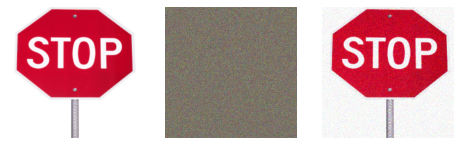

In [6]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

epsilon = 0.5 # set the epsilon

torch.manual_seed(0) # set the random seed when you use functions that uses sampling

noisy_img = attacks.noise(img, epsilon) # perform uniform random attack here [see the example in the Sec. 3.2.4 of the problem set]

print('epsilon=0.5')

print(get_prediction(noisy_img, net)) # output prediction, conf, and label_id using get_prediction function

imgutils.imshow([img, noisy_img-img, noisy_img], normd=True) #output the original image, the perturbation image, the perturbed image

epsilon=1
('doormat, welcome mat', 16.598552703857422, 539)


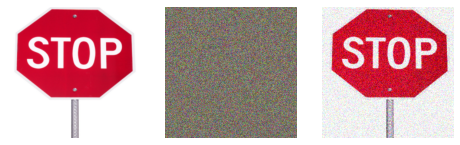

In [7]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

epsilon = 1 # set the epsilon

torch.manual_seed(0) # set the random seed when you use functions that uses sampling

noisy_img = attacks.noise(img, epsilon) # perform uniform random attack here [see the example in the Sec. 3.2.4 of the problem set]

print('epsilon=1')

print(get_prediction(noisy_img, net)) # output prediction, conf, and label_id using get_prediction function

imgutils.imshow([img, noisy_img-img, noisy_img], normd=True) #output the original image, the perturbation image, the perturbed image

**1c: FGM Attack**

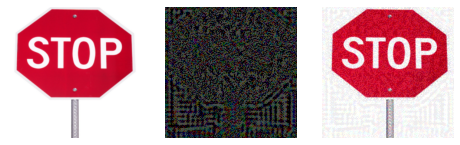

(('street sign', 13.558080673217773),
 ('doormat, welcome mat', 14.294464111328125))

In [8]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

images, true_labels, predicted_labels = one_call.attack(stop_sign_path, atk=attacks.FGM, nstr='resnet18', ret=True) # perform FGM attacks and return all the outputs

imgutils.imshow(images) # show all the images [original, perturbation, and adversarial]

true_labels, predicted_labels # show true and predicted labels

**1d: PGD Attack**

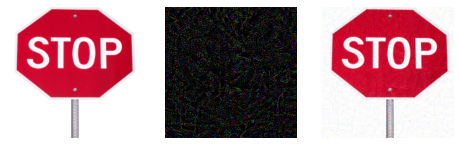

(('street sign', 13.558080673217773),
 ('streetcar, tram, tramcar, trolley, trolley car', 30.324739456176758))

In [9]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

target_class = 829 # imagenet id for street car

images, true_labels, predicted_labels = one_call.attack(stop_sign_path, atk=attacks.PGD, y=target_class, nstr='resnet18', ret=True) # perform PGD attacks and return all the outputs

imgutils.imshow(images) # show all the images [original, perturbation, and adversarial]

true_labels, predicted_labels #show true and predicted labels

**2a: AlexNet layer 0 visualization**

In [10]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

model = models.alexnet(pretrained=True).eval() #load pretrained alexnet

print(model) #show the alexnet structure

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


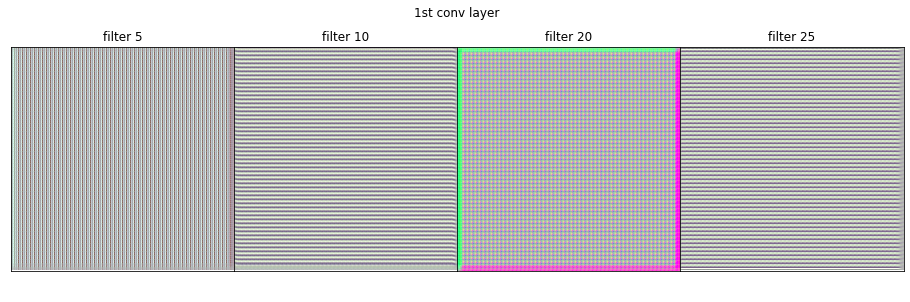

In [10]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

#load GradientAscent on GPU
g_ascent = GradientAscent(model.features)
g_ascent.use_gpu = True

layer_idx = 0 # set the layer index

filters = [5, 10, 20, 25] # set the filter numbers

layer = model.features[layer_idx] # select the 1st conv layer

g_ascent.visualize(layer, filters, title='1st conv layer') # call g_ascent.visualize() with the correct arguments to output the visualization



**2b: AlexNet layer 10 visualization**

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


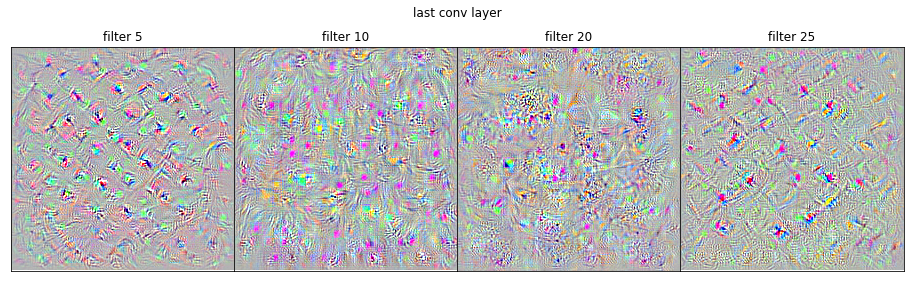

In [11]:
# MODIFY THE CODE FOR 2a TO VISUALIZE LAYER 10, FILTERS [5, 10, 15, 20] OF ALEXNET

# REPLACE THE THREE DOTS WITH YOUR OWN CODE

#load GradientAscent on GPU
g_ascent = GradientAscent(model.features)
g_ascent.use_gpu = True

layer_idx = 10 # set the layer index

filters = [5, 10, 20, 25] # set the filter numbers

layer = model.features[layer_idx] # select the last conv layer

g_ascent.visualize(layer, filters, title='last conv layer') # call g_ascent.visualize() with the correct arguments to output the visualization




**2c: AlexNet saliency map with the stop sign image**

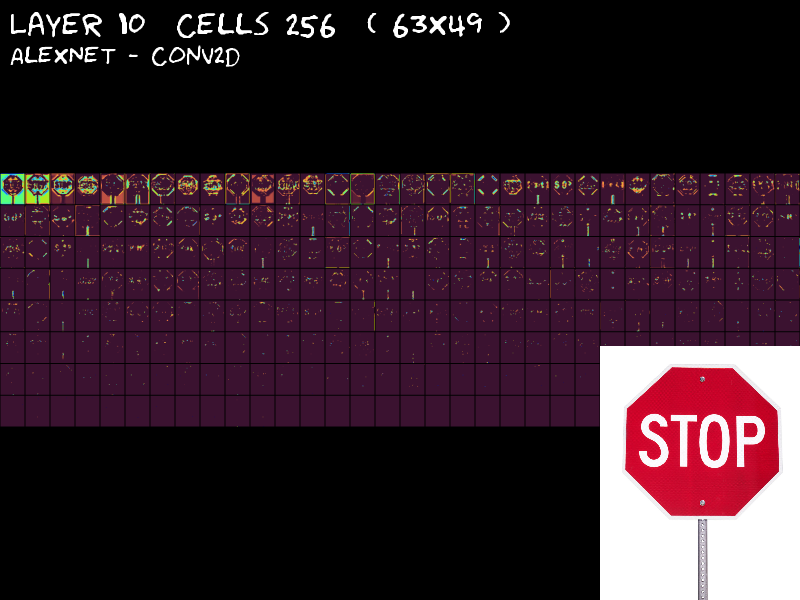

In [15]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

# load FeatureExtractor
from MapExtrackt import FeatureExtractor

layer_idx = 10 #define the layer index

fe = FeatureExtractor(model)

fe.set_image(stop_sign_path) # stop_sign_path is the path to the stop sign image

fe.display_from_map(layer_no=layer_idx)

**3: Example of plot with a confidence interval**



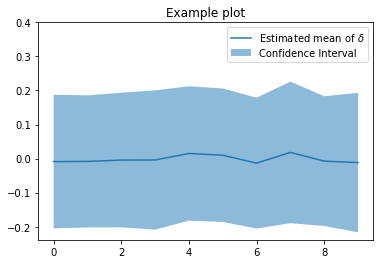

In [11]:
#THIS IS JUST AN EXAMPLE TO PLOT CONFIDENCE INTERVAL AS SHADED AREA

n = 500 # number of samples
k = 10  # number of replications
sigma = 0.2

torch.manual_seed(0) # set the random seed
deltas = torch.FloatTensor(sigma*torch.randn(n, k)) # gaussian samples ~ N(0, sigma*I)

# compute mean and standard deviation
mean_ = deltas.mean(dim=0)
std_ = deltas.std(dim=0)

# generate the plot
x = np.arange(k) # populate x axis
plt.plot(x, mean_, label="Estimated mean of $\delta$")
plt.fill_between(x, mean_ - std_, mean_ + std_, alpha=0.5, label="Confidence Interval") # 1-sigma confidence interval
plt.legend()
plt.ylim([None, 0.4]) 
plt.title('Example plot')
plt.show()

**Density computation example with log_prob**

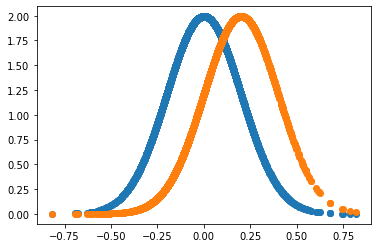

In [12]:
# THIS IS AN EXAMPLE TO USE log_prob METHOD FOR EASIER DENSITY COMPUTATION

# Suppose you want to compute the density of Normal distribution

# create Normal distribution object
p = Normal(torch.tensor([0.0]), torch.tensor([sigma]))       # N(0, sigma**2)
p_tilde = Normal(torch.tensor([0.2]), torch.tensor([sigma])) # N(1, sigma**2)

# use log_prob method
log_density_orig = p.log_prob(deltas) # log_prob method gives you log densities
log_density_tilde = p_tilde.log_prob(deltas) 

# verify this by plotting the density, i.e. the exp of the log_density
plt.scatter(deltas, torch.exp(log_density_orig), label="p")
plt.scatter(deltas, torch.exp(log_density_tilde), label="p_tilde")
plt.show()

**3a: MC estimator for prob. robustness of ResNet-18**

In [13]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

net = models.resnet18(pretrained=True).eval() # load resnet

sigma = 0.2# parameter sigma

# evaluate the model k times, each time use n samples
k = 10 # number of replications
n = 50 # number of samples in each replication

# collect the samples
torch.manual_seed(0) # set the random seed
deltas = torch.FloatTensor(sigma*torch.randn(*img.shape, n, k)) # gaussian samples ~ N(0, sigma*I)

resnet_test=np.zeros([n, k])

for i in range(k):
    for j in range(n):
        noisy_img = img + deltas[:, :, :, j, i]
        _, _, y_i = get_prediction(noisy_img, net)
        resnet_test[j, i] = y_i != true_class

In [46]:
print(deltas.shape)

torch.Size([3, 224, 224, 500, 10])


In [14]:
# compute the mean and standard deviation of your estimator
mu_hat_n_samples = resnet_test.mean(axis=0)

mean_ = mu_hat_n_samples.mean()
std_ = mu_hat_n_samples.std()

mean_, std_

(0.04, 0.029664793948382652)

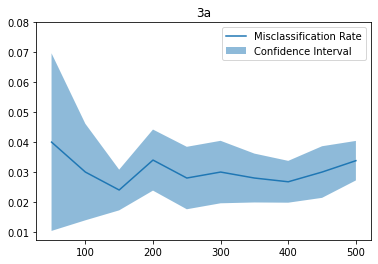

In [15]:
# REPEAT THE ABOVE EXAMPLE FOR n = [50, ..., 500]
n = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
mean = [0.04,0.030000000000000006,0.024,0.03400000000000001,0.028000000000000004,0.03,0.028000000000000004,0.026749999999999996,0.03,0.03380000000000001]
std = [0.029664793948382652,0.0161245154965971,0.00679869268479038,0.010198039027185569,0.010430723848324237,0.01043498389499902,0.008161632489763258,0.00698659430624106,0.008620962107231477,0.0066]
lower_bound = [mean[i]-std[i] for i in range(10)]
upper_bound = [mean[i]+std[i] for i in range(10)]

# PLOT THE MEAN AND THE CONFIDENCE INTERVAL OF THE k VALUES OF mu_hat_n VS n
plt.plot(n, mean, label="Misclassification Rate")
plt.fill_between(n, lower_bound, upper_bound, alpha=0.5, label="Confidence Interval") # 1-sigma confidence interval
plt.legend()
plt.ylim([None, 0.08]) 
plt.title('3a')
plt.show()

**3b: MC relative error**

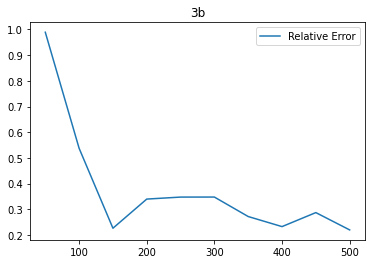

In [16]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

mu = 0.03 #true mu value

relative_error = [x/mu for x in std] # compute the relative error

# PLOT THE RELATIVE ERROR VS n
plt.plot(n, relative_error, label="Relative Error")
plt.legend()
plt.title('3b')
plt.show()

**3c: Misclassification rate w.r.t. samples close to an adversarial example**

In [17]:
images, true_labels, predicted_labels = one_call.attack(stop_sign_path, atk=attacks.FGM, nstr='resnet18', ret=True) 
xtilde = images[2]
# print(xtilde)
print(xtilde.shape)

torch.Size([3, 224, 224])


In [18]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

# repeat the FGM attack from problem 1c
images, true_labels, predicted_labels = one_call.attack(stop_sign_path, atk=attacks.FGM, nstr='resnet18', ret=True) 
xtilde = images[2].view(3,224,224,1,1)

# perform mean shift, closer to the adversarial example
scale = 1/3
mean_shift = scale*xtilde

# generate Gaussian samples centered at the mean_shift
net = models.resnet18(pretrained=True).eval() # load resnet
sigma = 0.2# parameter sigma
k = 10 # number of replications
n = 500 # number of samples in each replication
torch.manual_seed(0) # set the random seed
deltas = torch.FloatTensor(sigma*torch.randn(*img.shape, n, k))+mean_shift

resnet_test=np.zeros([n, k])

# compute misclassification rate using this new deltas, similar to 3a above
for i in range(k):
    for j in range(n):
        noisy_img = img + deltas[:, :, :, j, i]
        _, _, y_i = get_prediction(noisy_img, net)
        resnet_test[j, i] = y_i != true_class

In [19]:
# compute the mean and standard deviation of your estimator
mu_hat_n_samples = resnet_test.mean(axis=0)

mean_ = mu_hat_n_samples.mean()
std_ = mu_hat_n_samples.std()

mean_, std_

(0.4904, 0.02559374923687423)

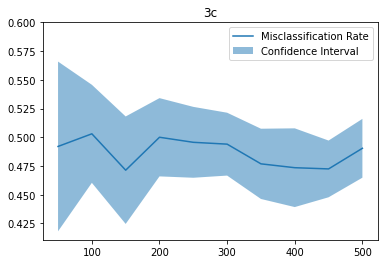

In [20]:
# REPEAT THE ABOVE EXAMPLE FOR n = [50, ..., 500]
n = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
mean = [0.492,0.5030000000000001,0.4713333333333334,0.5,0.49559999999999993,0.49399999999999994,0.47685714285714287,0.47350000000000003,0.4724444444444444,0.4904]
std = [0.07386474125047755,0.042673176586703755,0.04676655975278821,0.03405877273185282,0.03085190431723787,0.027357712704910914,0.030571428571428572,0.034263683398023624,0.024689678955255378,0.02559374923687423]
lower_bound = [mean[i]-std[i] for i in range(10)]
upper_bound = [mean[i]+std[i] for i in range(10)]

# PLOT THE MEAN AND THE CONFIDENCE INTERVAL OF THE k VALUES OF mu_hat_n VS n
plt.plot(n, mean, label="Misclassification Rate")
plt.fill_between(n, lower_bound, upper_bound, alpha=0.5, label="Confidence Interval") # 1-sigma confidence interval
plt.legend()
plt.ylim([None, 0.6]) 
plt.title('3c')
plt.show()

**3d: IS estimator**

In [21]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

# repeat the FGM attack from problem 1c
images, true_labels, predicted_labels = one_call.attack(stop_sign_path, atk=attacks.FGM, nstr='resnet18', ret=True) 
xtilde = images[2].view(3,224,224,1,1)

# perform mean shift, closer to the adversarial example
scale = 1/3
mean_shift = scale*xtilde

# generate Gaussian samples centered at the mean_shift
net = models.resnet18(pretrained=True).eval() # load resnet
sigma = 0.2# parameter sigma
k = 10 # number of replications
n = 200 # number of samples in each replication
torch.manual_seed(0) # set the random seed
deltas = torch.FloatTensor(sigma*torch.randn(*img.shape, n, k))+mean_shift

# use the sample generated in 3c and the log_prob method to compute the likelihood ratio
p = Normal(torch.tensor([0.0]), torch.tensor([sigma])) # N(0, sigma**2)

log_density_p = p.log_prob(deltas) # log_density per dimension for each sample under dist p = N(0, sigma**2)

log_density_ptilde = p.log_prob(deltas - mean_shift) # log_density per dimension for each sample under dist ptilde = N(mean_shift, sigma**2)

# compute log_likelihood per sample (assuming i.i.d. noise )
log_lkl_p = log_density_p.view(-1, log_density_p.size(3), log_density_p.size(4)).sum(axis=0)
log_lkl_ptilde = log_density_ptilde.view(-1, log_density_ptilde.size(3), log_density_ptilde.size(4)).sum(axis=0)

# compute likelihood ratio
lkl_ratio = torch.exp(log_lkl_p - log_lkl_ptilde)

# proceed to compute the IS estimator

resnet_test=np.zeros([n, k])

# compute misclassification rate using this new deltas, similar to 3a above
for i in range(k):
    for j in range(n):
        noisy_img = img + deltas[:, :, :, j, i]
        _, _, y_i = get_prediction(noisy_img, net)
        resnet_test[j, i] = y_i != true_class
        resnet_test[j, i] *= lkl_ratio[j, i]

In [22]:
# compute the mean and standard deviation of your estimator
mu_hat_n_samples = resnet_test.mean(axis=0)

mean_ = mu_hat_n_samples.mean()
std_ = mu_hat_n_samples.std()

mean_, std_

(0.0, 0.0)

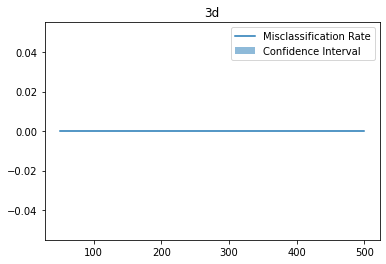

In [23]:
# similar to 3a, repeat for n = [50, ..., 500]
# plot the mean and the confidence interval of mu_hat_n vs n
n = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
mean = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]
std = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]
lower_bound = [mean[i]-std[i] for i in range(10)]
upper_bound = [mean[i]+std[i] for i in range(10)]

# PLOT THE MEAN AND THE CONFIDENCE INTERVAL OF THE k VALUES OF mu_hat_n VS n
plt.plot(n, mean, label="Misclassification Rate")
plt.fill_between(n, lower_bound, upper_bound, alpha=0.5, label="Confidence Interval") # 1-sigma confidence interval
plt.legend()
# plt.ylim([None, 0.6]) 
plt.title('3d')
plt.show()

**3e: IS relative error**

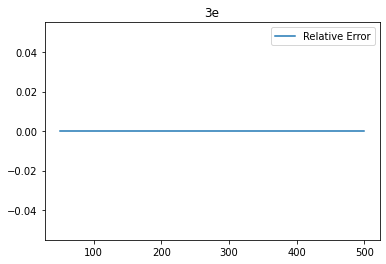

In [24]:
# similar to 3b, but use the IS result
mu = 0.03 #true mu value

relative_error = [x/mu for x in std] # compute the relative error

# PLOT THE RELATIVE ERROR VS n
plt.plot(n, relative_error, label="Relative Error")
plt.legend()
plt.title('3e')
plt.show()